<b><h4>HW3 - Notebook: Multi-Layer perceptron</h4></b>

[CE40477: Machine Learning](https://www.sharifml.ir/)

__Course Instructor__: Dr. Sharifi-Zarchi

__Notebook Authors__: Amir Ezzati & Ali Bavafa

Name: Bardia Mandegar                  
Student-ID: 401170637

# Import & Helper Functions

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gdown
from sklearn.datasets import fetch_openml
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import time
import random

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset

from tqdm.auto import tqdm
from IPython.display import display

In [45]:
def seed_setter(seed=None, seed_torch=True):
  """
  Function that controls randomness.

  Args:
    seed : Integer
      A non-negative integer that defines the random state.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):

  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)


def train_test_classification(net, criterion, optimizer, train_loader,
                              test_loader, num_epochs=1, verbose=True,
                              training_plot=False):
  """
  Accumulate training loss/Evaluate performance

  Args:
    net: Instance of Net class
      Describes the model with ReLU activation, batch size 128
    criterion: torch.nn type
      Criterion combines LogSoftmax and NLLLoss in one single class.
    optimizer: torch.optim type
      Implements Adam algorithm.
    train_loader: torch.utils.data type
      Combines the train dataset and sampler, and provides an iterable over the given dataset.
    test_loader: torch.utils.data type
      Combines the test dataset and sampler, and provides an iterable over the given dataset.
    num_epochs: int
      Number of epochs [default: 1]
    verbose: boolean
      If True, print statistics
    training_plot=False
      If True, display training plot

  Returns:
    Nothing
  """
  net.train()
  train_losses = []
  for epoch in tqdm(range(num_epochs)):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
      # Get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      inputs = inputs.float()
      labels = labels.long()

      optimizer.zero_grad()
      outputs = net(inputs)

      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      if verbose:
        train_losses += [loss.item()]

  net.eval()

  def test(data_loader):
    """
    Function to gauge network performance

    Args:
      data_loader: torch.utils.data type
        Combines the test dataset and sampler, and provides an iterable over the given dataset.

    Returns:
      acc: float
        Performance of the network
      total: int
        Number of datapoints in the dataloader
    """
    correct = 0
    total = 0
    for data in data_loader:
      inputs, labels = data
      inputs = inputs.float()
      labels = labels.long()

      outputs = net(inputs)
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    return total, acc

  train_total, train_acc = test(train_loader)
  test_total, test_acc = test(test_loader)

  if verbose:
    print(f'\nAccuracy on the {train_total} training samples: {train_acc:0.2f}')
    print(f'Accuracy on the {test_total} testing samples: {test_acc:0.2f}\n')

  if training_plot:
    plt.plot(train_losses)
    plt.xlabel('Batch')
    plt.ylabel('Training loss')
    plt.show()

  return train_acc, test_acc


def shuffle_and_split_data(X, y, seed):
  """
  Helper function to shuffle and split data

  Args:
    X: torch.tensor
      Input data
    y: torch.tensor
      Corresponding target variables
    seed: int
      Set seed for reproducibility

  Returns:
    X_test: torch.tensor
      Test data [20% of X]
    y_test: torch.tensor
      Labels corresponding to above mentioned test data
    X_train: torch.tensor
      Train data [80% of X]
    y_train: torch.tensor
      Labels corresponding to above mentioned train data
  """
  # Set seed for reproducibility
  torch.manual_seed(seed)
  # Number of samples
  N = X.shape[0]
  # Shuffle data
  shuffled_indices = torch.randperm(N)
  X = X[shuffled_indices]
  y = y[shuffled_indices]

  test_size = int(0.2 * N)
  X_test = X[:test_size]
  y_test = y[:test_size]
  X_train = X[test_size:]
  y_train = y[test_size:]

  return X_test, y_test, X_train, y_train


def sample_grid(M=500, x_max=2.0):
  """
  Helper function to simulate sample meshgrid

  Args:
    M: int
      Size of the constructed tensor with meshgrid
    x_max: float
      Defines range for the set of points

  Returns:
    X_all: torch.tensor
      Concatenated meshgrid tensor
  """
  ii, jj = torch.meshgrid(torch.linspace(-x_max, x_max,M),
                          torch.linspace(-x_max, x_max, M),
                          indexing='ij')
  X_all = torch.cat([ii.unsqueeze(-1),
                     jj.unsqueeze(-1)],
                     dim=-1).view(-1, 2)
  return X_all


def plot_decision_map(X_all, y_pred, X_test, y_test,
                      M=500, x_max=2.0, eps=1e-3):
  """
  Helper function to plot decision map

  Args:
    X_all: torch.tensor
      Concatenated meshgrid tensor
    y_pred: torch.tensor
      Labels predicted by the network
    X_test: torch.tensor
      Test data
    y_test: torch.tensor
      Labels of the test data
    M: int
      Size of the constructed tensor with meshgrid
    x_max: float
      Defines range for the set of points
    eps: float
      Decision threshold

  Returns:
    Nothing
  """
  decision_map = torch.argmax(y_pred, dim=1)

  for i in range(len(X_test)):
    indeces = (X_all[:, 0] - X_test[i, 0])**2 + (X_all[:, 1] - X_test[i, 1])**2 < eps
    decision_map[indeces] = (K + y_test[i]).long()

  decision_map = decision_map.view(M, M).cpu()
  plt.imshow(decision_map, extent=[-x_max, x_max, -x_max, x_max], cmap='jet')
  plt.axis('off')
  plt.plot()


def plot_function_apx(x_vals, relu_activations, predicted_output):
    """
    Visualizes ReLU activations and the resulting function approximation.

    Args:
      x_vals: torch.tensor
        Input x-axis data points.
      relu_activations: torch.tensor
        Calculated ReLU activations along x-axis for each ReLU unit.
      predicted_output: torch.tensor
        Estimated output labels or function approximations (weighted sum of ReLUs).

    Returns:
      None
    """

    fig, axes = plt.subplots(2, 1, figsize=(8, 6))

    ## Plot ReLU activations
    axes[0].plot(x_vals, relu_activations.T)
    axes[0].set_xlabel('x-values', fontsize=12)
    axes[0].set_ylabel('Activation Levels', fontsize=12)
    axes[0].set_title('ReLU Activations (Basis Functions)', fontsize=14)
    relu_labels = [f"ReLU {i + 1}" for i in range(relu_activations.shape[0])]
    axes[0].legend(relu_labels, ncol=2)

    ## Plot the function approximation and the ground truth
    axes[1].plot(x_vals, torch.sin(x_vals), label='Ground Truth (sin(x))', color='g', linewidth=2)
    axes[1].plot(x_vals, predicted_output, label='Predicted Output', linestyle='--', color='r')
    axes[1].set_xlabel('x-values', fontsize=12)
    axes[1].set_ylabel('y(x)', fontsize=12)
    axes[1].set_title('Function Approximation vs Ground Truth', fontsize=14)
    axes[1].legend()

    plt.tight_layout(pad=2)
    plt.show()


def show_images(image, num_row=2, num_col=5):
    # plot images
    image_size = int(np.sqrt(image.shape[-1]))
    image = np.reshape(image, (image.shape[0], image_size, image_size))
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(num_row*num_col):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(image[i], cmap='gray', vmin=0, vmax=1)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


SEED = 2024
# Call `seed_setter` to ensure reproducibility.
seed_setter(seed=SEED)

Random seed 2024 has been set.


# Loading the data

In [46]:
# Load data
mnist_data = fetch_openml("mnist_784")
x = mnist_data["data"].astype('float').to_numpy()
y = mnist_data["target"].astype('int')

# Normalize
x /= 255.0

# One-hot encode labels
num_labels = len(np.unique(y))
y_new = to_categorical(y, num_labels)

# -------------------------------- TODO -------------------------------------
# In this section, split the data into training and test datasets, using 60,000 samples for training and the remaining samples for testing.
x_train, x_test, y_train, y_test = train_test_split(x, y_new, test_size=10000, random_state=SEED)
# -------------------------------- TODO -------------------------------------

Training data: (60000, 784) (60000, 10)
Test data: (10000, 784) (10000, 10)


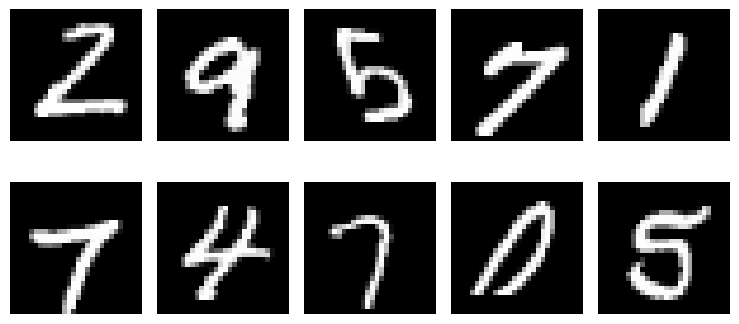

In [47]:
print("Training data: {} {}".format(x_train.shape, y_train.shape))
print("Test data: {} {}".format(x_test.shape, y_test.shape))
show_images(x_train)

# Activation Functions & Optimizers

There are many activation functions which some of them listed below. In this section you should implement them.

1. Sigmoid:
$$
\operatorname{sigmoid}(x) = \frac{1}{1 + \exp(-x)}
$$

2. Softmax: $$\operatorname{softmax}(\mathbf X)_{ij} = \frac{\exp(\mathbf X_{ij})}{\sum_k \exp \mathbf X_{ik})}.$$


3. Tanh (Hyperbolic Tangent):
$$
\operatorname{tanh}(x) = \frac{\sinh(x)}{\cosh(x)} = \frac{\exp(x) - \exp(-x)}{\exp(x) + \exp(-x)}
$$

4. ReLU: $$\operatorname{ReLU}(x) = \max(0, x)$$

5. Leaky ReLU:
$$
\operatorname{LeakyReLU}(x) =
\begin{cases}
x & \text{if } x \geq 0 \\
\alpha x & \text{if } x < 0
\end{cases}
$$
where \( $\alpha$ \) is a small constant (e.g., 0.01).

6. ELU (Exponential Linear Unit):
$$
\operatorname{ELU}(x) =
\begin{cases}
x & \text{if } x > 0 \\
\alpha (\exp(x) - 1) & \text{if } x \leq 0
\end{cases}
$$
where ($\alpha$) is a positive constant.

7. SELU (Scaled Exponential Linear Unit):
$$
\operatorname{SELU}(x) =
\lambda
\begin{cases}
x & \text{if } x > 0 \\
\alpha (\exp(x) - 1) & \text{if } x \leq 0
\end{cases}
$$
where \( $\lambda$ \) and \( $\alpha$ \) are predefined constants, typically \( $\lambda \approx 1.0507$ \) and \( $\alpha \approx 1.67326$ \).


------
There are several optimizer algorithms for optimizing the neural network over epochs. You should implement some of those mentioned in this section:

***Stochastic Gradient Descent (SGD)***

SGD is the basic form of gradient descent, where each weight (\( w \)) and bias (\( b \)) parameter is updated in the opposite direction of its gradient.

**Update Rule:**
$$
w^{(t+1)} = w^{(t)} - \eta \cdot \nabla_w L(w^{(t)}, b^{(t)})
$$
$$
b^{(t+1)} = b^{(t)} - \eta \cdot \nabla_b L(w^{(t)}, b^{(t)})
$$

- \( w \): Weight parameters
- \( b \): Bias parameters
- \( $\eta$ \): Learning rate
- \( $\nabla_w L(w, b)$ \): Gradient of the loss with respect to \( w \)
- \( $\nabla_b L(w, b)$ \): Gradient of the loss with respect to \( b \)

<br><br>

***Momentum Optimizer***

Momentum optimizer smooths parameter updates by adding a velocity term to accumulate past gradients.

**Update Rule:**
1. **Velocity Update for Weights and Biases:**
   $$
   v_w^{(t+1)} = \beta \cdot v_w^{(t)} + (1 - \beta) \cdot \nabla_w L(w^{(t)}, b^{(t)})
   $$
   $$
   v_b^{(t+1)} = \beta \cdot v_b^{(t)} + (1 - \beta) \cdot \nabla_b L(w^{(t)}, b^{(t)})
   $$

2. **Parameter Update:**
   $$
   w^{(t+1)} = w^{(t)} - \eta \cdot v_w^{(t+1)}
   $$
   $$
   b^{(t+1)} = b^{(t)} - \eta \cdot v_b^{(t+1)}
   $$

- \( $v_w$ \): Velocity term for weights
- \( $v_b$ \): Velocity term for biases
- \( $\beta$ \): Momentum term, typically set to 0.9

<br><br>

***Adam Optimizer***

Adam combines momentum and adaptive learning rates, using both first (momentum) and second (RMSprop) moment estimates.

**Update Rule:**
1. **Compute biased first and second moment estimates:**
   $$
   m_w^{(t+1)} = \beta_1 \cdot m_w^{(t)} + (1 - \beta_1) \cdot \nabla_w L(w^{(t)}, b^{(t)})
   $$
   $$
   m_b^{(t+1)} = \beta_1 \cdot m_b^{(t)} + (1 - \beta_1) \cdot \nabla_b L(w^{(t)}, b^{(t)})
   $$
   $$
   v_w^{(t+1)} = \beta_2 \cdot v_w^{(t)} + (1 - \beta_2) \cdot \left( \nabla_w L(w^{(t)}, b^{(t)}) \right)^2
   $$
   $$
   v_b^{(t+1)} = \beta_2 \cdot v_b^{(t)} + (1 - \beta_2) \cdot \left( \nabla_b L(w^{(t)}, b^{(t)}) \right)^2
   $$

2. **Compute bias-corrected estimates:**
   $$
   \hat{m}_w^{(t+1)} = \frac{m_w^{(t+1)}}{1 - \beta_1^{t+1}}, \quad \hat{m}_b^{(t+1)} = \frac{m_b^{(t+1)}}{1 - \beta_1^{t+1}}
   $$
   $$
   \hat{v}_w^{(t+1)} = \frac{v_w^{(t+1)}}{1 - \beta_2^{t+1}}, \quad \hat{v}_b^{(t+1)} = \frac{v_b^{(t+1)}}{1 - \beta_2^{t+1}}
   $$

3. **Parameter Update:**
   $$
   w^{(t+1)} = w^{(t)} - \eta \cdot \frac{\hat{m}_w^{(t+1)}}{\sqrt{\hat{v}_w^{(t+1)}} + \epsilon}
   $$
   $$
   b^{(t+1)} = b^{(t)} - \eta \cdot \frac{\hat{m}_b^{(t+1)}}{\sqrt{\hat{v}_b^{(t+1)}} + \epsilon}
   $$

- \( $m_w$ \), \( $m_b$ \): First moment estimates (mean of gradients) for weights and biases
- \( $v_w$ \), \( $v_b$ \): Second moment estimates (uncentered variance of gradients) for weights and biases
- \( $\beta_1$ \): Decay rate for first moment, typically 0.9
- \( $\beta_2$ \): Decay rate for second moment, typically 0.999
- \( $\epsilon$ \): Small constant for numerical stability (e.g., \(10^{-8}\))

# MLP from Scratch

In [48]:
class MLP():
    def __init__(self, sizes, activation='sigmoid'):
        self.sizes = sizes
        self.num_layers = len(sizes) - 1  # number of layers excluding input
        self.activation_name = activation

        # Choose activation function
        if activation == 'relu':
            self.activation = self.relu
        elif activation == 'tanh':
            self.activation = self.tanh
        elif activation == 'sigmoid':
            self.activation = self.sigmoid
        # -------------------------------- TODO -------------------------------------
        # Do the same for other activation functions
        elif activation == 'softmax':
            self.activation = self.softmax
        elif activation == 'leaky_relu':
            self.activation = self.leaky_relu
        elif activation == 'elu':
            self.activation = self.elu
        elif activation == 'selu':
            self.activation = self.selu
        # -------------------------------- TODO -------------------------------------
        else:
            raise ValueError("This activation function is currently not supported!")

        # Save all weights
        self.params = self.initialize()
        # Save all intermediate values, i.e. activations
        self.cache = {}


    # Activation functions remain the same as defined in your original code
    def relu(self, x, derivative=False):
        '''
            Forward path:
            relu(x) = max(0, x)
            In other word,
            relu(x) = 0, if x < 0
                    = x, if x >= 0

            Backward path:
            ∇relu(x) = 0, if x < 0
                     = 1, if x >=0
        '''
        # -------------------------------- TODO -------------------------------------
        if derivative:
            return np.where(x <= 0, 0, 1)
        else:
            return np.maximum(0, x)
        # -------------------------------- TODO -------------------------------------


    def tanh(self, x, derivative=False):
        '''
            Forward path:
            tanh(x) = (exp(x) - exp(-x)) / (exp(x) + exp(-x))

            Backward path:
            ∇tanh(x) = 1 - tanh(x)^2
        '''
        # -------------------------------- TODO -------------------------------------
        if derivative:
            return 1 - np.tanh(x) ** 2
        else:
            return np.tanh(x)
        # -------------------------------- TODO -------------------------------------


    def sigmoid(self, x, derivative=False):
        '''
            Forward path:
            σ(x) = 1 / 1+exp(-z)

            Backward path:
            ∇σ(x) = exp(-z) / (1+exp(-z))^2
        '''
        # -------------------------------- TODO -------------------------------------
        if derivative:
            return np.exp(-x) / (1 + np.exp(-x)) ** 2
        else:
            return 1 / (1 + np.exp(-x))
        # -------------------------------- TODO -------------------------------------


    def softmax(self, x):
        '''
            softmax(x) = exp(x) / ∑exp(x)
        '''
        # Numerically stable with large exponentials
        # -------------------------------- TODO -------------------------------------
        return np.exp(x) / np.sum(np.exp(x), axis=0)
        # -------------------------------- TODO -------------------------------------


    def leaky_relu(self, x, alpha=0.01, derivative=False):
        '''
            Forward path:
            leaky_relu(x) = x if x >= 0 else αx

            Backward path:
            ∇leaky_relu(x) = 1 if x >= 0 else α
        '''
        # -------------------------------- TODO -------------------------------------
        if derivative:
            return np.where(x >= 0, 1, alpha)
        else:
            return np.maximum(alpha * x, x)
        # -------------------------------- TODO -------------------------------------


    def elu(self, x, alpha=1.0, derivative=False):
        '''
            Forward path:
            elu(x) = x if x > 0 else α(exp(x) - 1)

            Backward path:
            ∇elu(x) = 1 if x > 0 else α * exp(x)
        '''
        # -------------------------------- TODO -------------------------------------
        if derivative:
            return np.where(x > 0, 1, alpha * np.exp(x))
        else:
            return np.where(x > 0, x, alpha * (np.exp(x) - 1))
        # -------------------------------- TODO -------------------------------------


    def selu(self, x, lambda_=1.0507, alpha=1.67326, derivative=False):
        '''
            Forward path:
            selu(x) = λ * (x if x > 0 else α * (exp(x) - 1))

            Backward path:
            ∇selu(x) = λ * (1 if x > 0 else α * exp(x))
        '''
        # -------------------------------- TODO -------------------------------------
        if derivative:
            return lambda_ * np.where(x > 0, 1, alpha * np.exp(x))
        else:
            return lambda_ * np.where(x > 0, x, alpha * (np.exp(x) - 1))
        # -------------------------------- TODO -------------------------------------


    def initialize(self):
        params = {}
        for i in range(1, self.num_layers + 1):
            input_layer = self.sizes[i - 1]
            output_layer = self.sizes[i]
            params[f"W{i}"] = np.random.randn(output_layer, input_layer) * np.sqrt(1. / input_layer)
            params[f"b{i}"] = np.zeros((output_layer, 1))
        return params


    def feed_forward(self, x):
        self.cache["A0"] = x.T
        # -------------------------------- TODO -------------------------------------
        # Perform feedforward pass through each hidden layer, applying weights, biases, and activation function
        for i in range(1, self.num_layers + 1):
            self.cache[f"Z{i}"] = np.dot(self.params[f"W{i}"], self.cache[f"A{i - 1}"]) + self.params[f"b{i}"]
            self.cache[f"A{i}"] = self.activation(self.cache[f"Z{i}"])
        # -------------------------------- TODO -------------------------------------
        return self.cache[f"A{self.num_layers}"]


    def back_propagate(self, y, output):
        current_batch_size = y.shape[0]
        grads = {}
        # -------------------------------- TODO -------------------------------------
        # Backpropagate gradients through Output layer and each hidden layers
        for i in range(self.num_layers, 0, -1):
            if i == self.num_layers:
                grads[f"dZ{i}"] = output - y.T
            else:
                grads[f"dZ{i}"] = self.params[f"W{i + 1}"].T @ grads[f"dZ{i + 1}"] * self.activation(self.cache[f"Z{i}"], derivative=True)

            grads[f"dW{i}"] = np.dot(grads[f"dZ{i}"], self.cache[f"A{i - 1}"].T) / current_batch_size
            grads[f"db{i}"] = np.sum(grads[f"dZ{i}"], axis=1, keepdims=True) / current_batch_size
        # -------------------------------- TODO -------------------------------------
        self.grads = grads
        return self.grads


    def cross_entropy_loss(self, y, output):
        '''
            L(y, ŷ) = −∑ylog(ŷ).
        '''
        # -------------------------------- TODO -------------------------------------
        # Compute cross-entropy loss as the negative average log-likelihood of the correct labels
        # loss = 0.0
        # for i in range(y.shape[0]):
        #     for j in range(y.shape[1]):
        #         if np.abs(y[i, j] - 1) < 1e-4:
        #             loss += -np.log(self.softmax(output)[j, i] + 1e-6)
        #             break
        # return loss / y.shape[0]

        softmax_output = self.softmax(output.T)

        correct_class_probs = np.sum(y * softmax_output, axis=1)  # Select correct class probabilities

        loss = -np.mean(np.log(correct_class_probs + 1e-6))  # Add epsilon to avoid log(0)

        return loss
        # -------------------------------- TODO -------------------------------------


    def initialize_momemtum_optimizer(self):
        momemtum_opt = {}
        for i in range(1, self.num_layers + 1):
            # -------------------------------- TODO -------------------------------------
            # Initialize zero matrices for momentum updates of weights and biases in each layer
            momemtum_opt[f"VW{i}"] = np.zeros_like(self.params[f"W{i}"])
            momemtum_opt[f"Vb{i}"] = np.zeros_like(self.params[f"b{i}"])
            # -------------------------------- TODO -------------------------------------
        return momemtum_opt


    def initialize_adam_optimizer(self):
        adam_opt = {}
        for i in range(1, self.num_layers + 1):
            # -------------------------------- TODO -------------------------------------
            # Initialize zero matrices for first and second moment estimates of weights and biases in each layer
            adam_opt[f"VW{i}"] = np.zeros_like(self.params[f"W{i}"])
            adam_opt[f"Vb{i}"] = np.zeros_like(self.params[f"b{i}"])
            adam_opt[f"SW{i}"] = np.zeros_like(self.params[f"W{i}"])
            adam_opt[f"Sb{i}"] = np.zeros_like(self.params[f"b{i}"])
            # -------------------------------- TODO -------------------------------------
        return adam_opt


    def optimize(self, l_rate=0.1, beta=.9, beta1=0.9, beta2=0.999, epsilon=1e-8, t=1):

        if self.optimizer == "sgd":
            for key in self.params:
                # -------------------------------- TODO -------------------------------------
                # Update rule for SGD
                self.params[key] -= l_rate * self.grads[f"d{key}"]
                # -------------------------------- TODO -------------------------------------
        elif self.optimizer == "momentum":
            for key in self.params:
                # -------------------------------- TODO -------------------------------------
                # Update rule for Momentum
                self.momemtum_opt[f"V{key}"] = beta * self.momemtum_opt[f"V{key}"] + (1 - beta) * self.grads[f"d{key}"]
                self.params[key] -= l_rate * self.momemtum_opt[f"V{key}"]
                # -------------------------------- TODO -------------------------------------
        elif self.optimizer == "adam":
            for key in self.params:
                # -------------------------------- TODO -------------------------------------
                # Update rule for Adam
                self.adam_opt[f"V{key}"] = beta1 * self.adam_opt[f"V{key}"] + (1 - beta1) * self.grads[f"d{key}"]
                self.adam_opt[f"S{key}"] = beta2 * self.adam_opt[f"S{key}"] + (1 - beta2) * self.grads[f"d{key}"] ** 2
                V_corrected = self.adam_opt[f"V{key}"] / (1 - beta1 ** t)
                S_corrected = self.adam_opt[f"S{key}"] / (1 - beta2 ** t)
                self.params[key] -= l_rate * V_corrected / (np.sqrt(S_corrected) + epsilon)
                # -------------------------------- TODO -------------------------------------
        else:
            raise ValueError("This optimizer is currently not supported!")

    # Accuracy, loss, and training methods remain the same as defined in your original code


    def accuracy(self, y, output):
        # -------------------------------- TODO -------------------------------------
        # Calculate accuracy by comparing the pred and truth matrices
        pred = np.argmax(output, axis=0)
        truth = np.argmax(y.T, axis=0)
        acc = np.mean(pred == truth)

        return acc
        # -------------------------------- TODO --------------------------------------


    def train(self, x_train, y_train, x_val, y_val, epochs=10,
              batch_size=64, optimizer='momentum', l_rate=0.1, beta=.9, beta1=0.9, beta2=0.999, epsilon=1e-8, t=1):
        # Hyperparameters
        self.epochs = epochs
        self.batch_size = batch_size
        num_batches = -(-x_train.shape[0] // self.batch_size)

        # Initialize optimizer
        self.optimizer = optimizer
        if self.optimizer == 'momentum':
          self.momemtum_opt = self.initialize_momemtum_optimizer()
        elif self.optimizer == 'adam':
          self.adam_opt = self.initialize_adam_optimizer()

        start_time = time.time()

        # Train
        for i in range(self.epochs):
            # Shuffle
            permutation = np.random.permutation(x_train.shape[0])
            x_train_shuffled = x_train[permutation]
            y_train_shuffled = y_train[permutation]

            for j in range(num_batches):
                # Batch
                begin = j * self.batch_size
                end = min(begin + self.batch_size, x_train.shape[0]-1)
                x = x_train_shuffled[begin:end]
                y = y_train_shuffled[begin:end]

                # Forward
                output = self.feed_forward(x)
                # Backprop
                grad = self.back_propagate(y, output)
                # Optimize
                self.optimize(l_rate=l_rate, beta=beta, beta1=beta1, beta2=beta2, epsilon=epsilon, t=t)

            # Evaluate performance
            # Training data
            output = self.feed_forward(x_train)
            train_acc = self.accuracy(y_train, output)
            train_loss = self.cross_entropy_loss(y_train, output)
            # Test data
            output = self.feed_forward(x_val)
            val_acc = self.accuracy(y_val, output)
            val_loss = self.cross_entropy_loss(y_val, output)
            print(f'Epoch {i+1}: {time.time()-start_time:.2f}s, train acc={train_acc:.2f}, train loss={train_loss:.2f}, '
                      f'validation acc={val_acc:.2f}, validation loss={val_loss:.2f}')


    def evaluate(self, x_test, y_test):
        # Test data
        output = self.feed_forward(x_test)
        test_acc = self.accuracy(y_test, output)
        test_loss = self.cross_entropy_loss(y_test, output)
        print(f'\nTest acc={test_acc:.2f}, Test loss={test_loss:.2f}')
        return test_loss, test_acc

Please run experiments with different combinations of optimizers (SGD, Momentum, and Adam) and activation functions (ReLU, Sigmoid, Tanh, Leaky ReLU, SELU, and ELU) over 20 epochs each. Consider networks with three layers (without input layer) whose number of neurons is 128, 64 and 10 respectively. Also consider two learning rates 0.01 and 0.001.


After testing all combinations, report which combination of optimizer, activation function, and learning rate performs best.




In [49]:
# Run your experiments here ...

optimizers = ['sgd', 'momentum', 'adam']
activation_functions = ['relu', 'sigmoid', 'tanh', 'leaky_relu', 'selu', 'elu']
learning_rates = [0.01, 0.001]

best_accuracy = 0
best_optimizer = None
best_activation_function = None
best_learning_rate = None

for optimizer in optimizers:
  for activation_function in activation_functions:
    for learning_rate in learning_rates:
      print(f"Optimizer: {optimizer}, Activation Function: {activation_function}, Learning Rate: {learning_rate}")
      model = MLP([784, 128, 64, 10], activation=activation_function)
      model.train(x_train, y_train, x_test, y_test, epochs=20, batch_size=64, optimizer=optimizer, l_rate=learning_rate)
      loss, accuracy = model.evaluate(x_test, y_test)
      if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_optimizer = optimizer
        best_activation_function = activation_function
        best_learning_rate = learning_rate
      print("\n")

print(f"Best test accuracy: {best_accuracy}")
print(f"Best optimizer: {best_optimizer}")
print(f"Best activation function: {best_activation_function}")
print(f"Best learning rate: {best_learning_rate}")


Optimizer: sgd, Activation Function: relu, Learning Rate: 0.01
Epoch 1: 3.73s, train acc=0.86, train loss=10.44, validation acc=0.85, validation loss=8.69
Epoch 2: 9.04s, train acc=0.90, train loss=10.36, validation acc=0.89, validation loss=8.61
Epoch 3: 12.28s, train acc=0.92, train loss=10.33, validation acc=0.90, validation loss=8.58
Epoch 4: 15.31s, train acc=0.92, train loss=10.31, validation acc=0.91, validation loss=8.56
Epoch 5: 19.94s, train acc=0.93, train loss=10.29, validation acc=0.92, validation loss=8.54
Epoch 6: 24.83s, train acc=0.94, train loss=10.28, validation acc=0.93, validation loss=8.53
Epoch 7: 27.88s, train acc=0.94, train loss=10.28, validation acc=0.93, validation loss=8.52
Epoch 8: 31.16s, train acc=0.94, train loss=10.27, validation acc=0.94, validation loss=8.52
Epoch 9: 35.59s, train acc=0.95, train loss=10.27, validation acc=0.94, validation loss=8.51
Epoch 10: 41.13s, train acc=0.95, train loss=10.26, validation acc=0.94, validation loss=8.50
Epoch 11

# MLP as function Approximator
We know that a MLP with one hidden layer could  approximate any smooth function! <br> Here you will manually fit a sine function using ReLU activation. <br>You need to set the correct weights on ReLUs so the linear combination approximates the desired function.


ValueError: only one element tensors can be converted to Python scalars

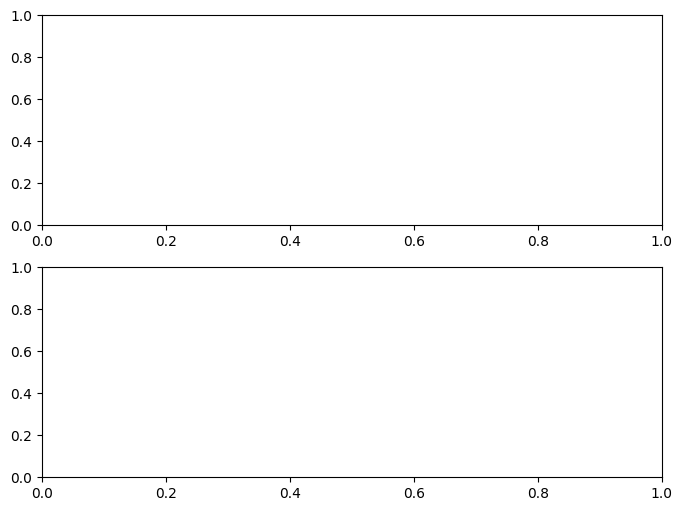

In [50]:
def relu_approximation(input_data, target_labels):
    """
    Args:
      input_data: torch.tensor
        Input training data
      target_labels: torch.tensor
        Ground truth labels for training data

    Returns:
      activation_map: torch.tensor
        ReLU activations computed across the x-axis
      predicted_labels: torch.tensor
        Estimated labels or class predictions
        Derived from weighted sum of ReLU activations along the x-axis
      x_points: torch.tensor
        Points along the x-axis
    """
    ##############################---TODO---##############################
    # Number of ReLU units
    num_relus = input_data.shape[0] - 1

    # Generate dense x-axis points for interpolation
    x_points = torch.linspace(torch.min(input_data), torch.max(input_data), 1000)

    # Compute bias for ReLU units
    biases = torch.linspace(torch.min(input_data), torch.max(input_data), num_relus + 1)[:num_relus]

    # Initialize activation map to store ReLU activations
    activation_map = torch.zeros(num_relus, x_points.shape[0])

    for relu_idx in range(num_relus):
        activation_map[relu_idx, :] = torch.relu(x_points - biases[relu_idx])

    ## WEIGHTED SUM OF RELUS

    relu_weights = torch.zeros(num_relus)
    prev_slope = 0
    for j in range(num_relus):
        slope = (target_labels[j + 1] - target_labels[j]) / (input_data[j + 1] - input_data[j])
        relu_weights[j] = slope - prev_slope
        prev_slope = slope

    # Compute predicted labels as weighted sum of ReLU activations
    predicted_labels = relu_weights @ activation_map
    ##############################---TODO---##############################

    return predicted_labels, activation_map, x_points


# Generate synthetic training data using sine function
num_samples = 10
input_data = torch.linspace(0, 2 * np.pi, num_samples).view(-1, 1)
target_labels = torch.sin(input_data)

predicted_output, activation_map, x_points = relu_approximation(input_data, target_labels)
plot_function_apx(x_points, activation_map, predicted_output)


# Depth vs. Width
Here we wanna see the effect of width vs. depth on a classification task.First you are going to implement MLP again; But with 2 differences: <br>

1.   It is general purpose (i.e. works for desired depth and activation functions)
2.   You will implement it using pytorch



In [51]:
class MLP_pytorch(nn.Module):
  """
  Simulate MLP Network
  """

  def __init__(self, activation_fn, input_feature_num, hidden_unit_nums, output_feature_num):
    """
    Initialize MLP Network parameters

    Args:
      activation_fn: string
        Activation function
      input_feature_num: int
        Number of input features
      hidden_unit_nums: list
        Number of units per hidden layer. List of integers
      output_feature_num: int
        Number of output features

    Returns:
      Nothing
    """
    super(MLP_pytorch, self).__init__()
    self.input_feature_num = input_feature_num
    self.mlp = nn.Sequential()

    in_num = input_feature_num
    ##############################---TODO---##############################
    for i in range(len(hidden_unit_nums)):
        self.mlp.add_module(f'Linear_{i}', nn.Linear(in_num, hidden_unit_nums[i]))
        in_num = hidden_unit_nums[i]
        self.mlp.add_module(f'Activation_{i}', getattr(nn, activation_fn)())
    out_layer = nn.Linear(in_num, output_feature_num) # final layer
    self.mlp.add_module('Output_Linear', out_layer)

    ##############################---TODO---##############################

  def forward(self, x):
    """
    Simulate forward pass of MLP Network

    Args:
      x: torch.tensor
        Input data

    Returns:
      logits: Instance of MLP
        Forward pass of MLP
    """
    # Reshape inputs to (batch_size, input_feature_num)
    x = x.view(-1, self.input_feature_num)
    logits = self.mlp(x) # forward pass

    return logits

Now let's make a spiral dataset that follows this formula:
\begin{equation}
\begin{array}{c}
X_{k}(t)=t\left(\begin{array}{c}
\sin \left[\frac{2 \pi}{K}\left(2 t+k-1\right)\right]+\mathcal{N}\left(0, \sigma\right) \\
\cos \left[\frac{2 \pi}{K}\left(2 t+k-1\right)\right]+\mathcal{N}\left(0, \sigma\right)
\end{array}\right)
\end{array}, \quad 0 \leq t \leq 1, \quad k=1, \ldots, K
\end{equation}

Run cell below to create the data and load it as tensors.

In [52]:
# @title Data Loader
K = 4
sigma = 0.4
N = 1000
t = torch.linspace(0, 1, N)
X = torch.zeros(K*N, 2)
y = torch.zeros(K*N)
for k in range(K):
  X[k*N:(k+1)*N, 0] = t*(torch.sin(2*np.pi/K*(2*t+k)) + sigma**2*torch.randn(N))
  X[k*N:(k+1)*N, 1] = t*(torch.cos(2*np.pi/K*(2*t+k)) + sigma**2*torch.randn(N))
  y[k*N:(k+1)*N] = k


X_test, y_test, X_train, y_train = shuffle_and_split_data(X, y, seed=SEED)

# DataLoader with random seed
batch_size = 128
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=batch_size,
                         shuffle=False, num_workers=0,
                         worker_init_fn=seed_worker,
                         generator=g_seed,
                         )

train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          drop_last=True,
                          shuffle=True,
                          worker_init_fn=seed_worker,
                          generator=g_seed,
                          )

Now we will add more polynomial features to the dataset to make the first layer wider. Afterwards, train a single linear layer. We could use the same MLP network with no hidden layers (though it would not be called an MLP anymore!).

Add polynomial terms up to $P=50$ which means that for every $x_1^n x_2^m$ term, $n+m\leq P$. Total number of polynomial features up to $P$ follows this formula:

\begin{equation}
\text{# of terms} = \frac{(P+1)(P+2)}{2}
\end{equation}

Also, we don't need the polynomial term with degree zero (which is the constatnt term) since `nn.Linear` layers have bias terms. Therefore we will have one fewer polynomial feature.

In [53]:
def polynomial_classifier(poly_degree, seed=0):
  """
  Helper function to run the polynomial classifier

  Args:
    poly_degree: int
      Degree of the polynomial
    seed: int
      A non-negative integer that defines the random state.

  Returns:
    num_features: int
      Number of features
  """

  def polynomial_features(poly_degree, X):
    """
    Function to define the number of polynomial features except the bias term

    Args:
      poly_degree: int
        Degree of the polynomial
      X: torch.tensor
        Input data

    Returns:
      num_features: int
        Number of features
      poly_X: torch.tensor
        Polynomial term
    """
    ##############################---TODO---##############################
    num_features = (poly_degree + 1) * (poly_degree + 2) // 2 - 1
    poly_X = torch.zeros((X.shape[0], num_features))
    count = 0
    for i in range(poly_degree + 1):
      for j in range(poly_degree + 1):
        if i + j > 0 and i + j <= poly_degree:
          poly_X[:, count] = X[:, 0] ** i * X[:, 1] ** j
          count += 1
    return poly_X, num_features
    ##############################---TODO---##############################

  poly_X_test, num_features = polynomial_features(poly_degree, X_test)
  poly_X_train, _ = polynomial_features(poly_degree, X_train)

  batch_size = 128

  g_seed = torch.Generator()
  g_seed.manual_seed(seed)
  poly_test_data = TensorDataset(poly_X_test, y_test)
  poly_test_loader = DataLoader(poly_test_data,
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=1,
                                worker_init_fn=seed_worker,
                                generator=g_seed)

  poly_train_data = TensorDataset(poly_X_train, y_train)
  poly_train_loader = DataLoader(poly_train_data,
                                 batch_size=batch_size,
                                 shuffle=True,
                                 num_workers=1,
                                 worker_init_fn=seed_worker,
                                 generator=g_seed)

  # Defining a linear model using MLP class
  poly_net = MLP_pytorch('ReLU()', num_features, [], K)

  # Train and test
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(poly_net.parameters(), lr=1e-3)
  _, _ = train_test_classification(poly_net, criterion, optimizer,
                                   poly_train_loader, poly_test_loader,
                                   num_epochs=100)
  X_all = sample_grid()
  poly_X_all, _ = polynomial_features(poly_degree, X_all)
  y_pred = poly_net(poly_X_all)

  # Plot
  plot_decision_map(X_all.cpu(), y_pred.cpu(), X_test.cpu(), y_test.cpu())
  plt.show()

  return num_features

### Train the network. How does it generalize?

Random seed 2024 has been set.


  0%|          | 0/100 [00:00<?, ?it/s]


Accuracy on the 3200 training samples: 69.97
Accuracy on the 800 testing samples: 69.38



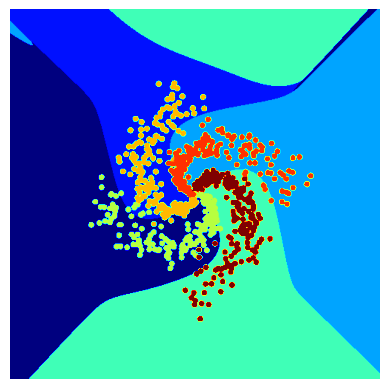

Number of features: 1325


In [54]:
seed_setter(seed=SEED)
max_poly_deg = 50
num_features = polynomial_classifier(max_poly_deg)
print(f'Number of features: {num_features}')

Now create another instance of `MLP_pytorch` class having a hidden layer of 128 neurons and train it. Compare the result with the wide network. How does deeper model generalize? Is the decision boundaries ideal? Why?

Random seed 2024 has been set.


  0%|          | 0/100 [00:00<?, ?it/s]


Accuracy on the 3200 training samples: 97.75
Accuracy on the 800 testing samples: 98.00



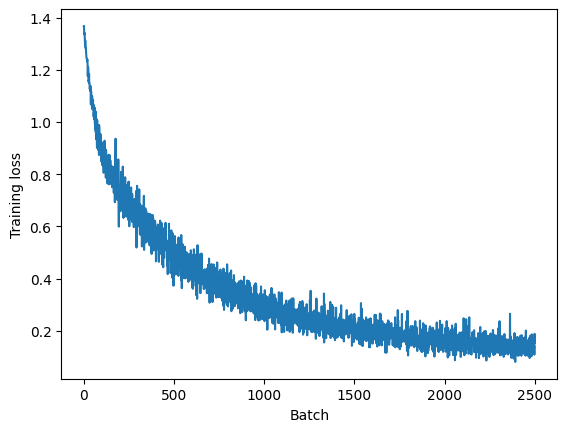

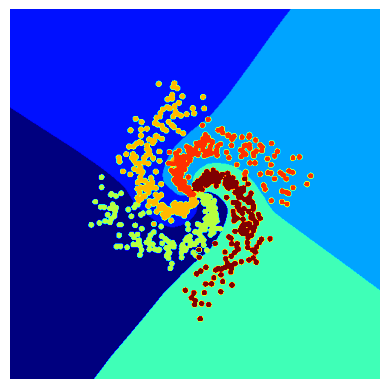

In [55]:
##############################---TODO---##############################
seed_setter(SEED)
net2 = MLP_pytorch('ReLU', 2, [128], K)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net2.parameters(), lr=1e-3)
num_epochs = 100

_, _ = train_test_classification(net2, criterion, optimizer, train_loader,
                                 test_loader, num_epochs=num_epochs,
                                 training_plot=True)

X_all = sample_grid()
y_pred = net2(X_all).cpu()
plot_decision_map(X_all, y_pred, X_test, y_test)

##############################---TODO---##############################